In [1]:
using DMUStudent
using DMUStudent.HW4: gw
# using POMDPs: actions, @gen, isterminal, discount, statetype, actiontype, simulate, states, initialstate
# using D3Trees: inchrome
 using StaticArrays: SA
using Statistics: mean, std, mean
# using LinearAlgebra
using Random
using CommonRLInterface: render, actions, act!, observe, reset!, AbstractEnv, observations, terminated, clone
# using Compose

In [2]:
env = DMUStudent.HW4.gw
# s = observe(env)
# actions(env)
# a = rand(actions(env))

# r = act!(env,a)
# observe(env)


# Q[(s,a)] = 1

observations(env)
actions(env)

Q = Dict((s, a) => 0.0 for s in observations(env), a in actions(env))
s = observe(env)
a = rand(actions(env))
r = act!(env, a)
sp = observe(env)


a_best = argmax(a->Q[(sp, a)], actions(env))
# Q[(sp, a_best)]
# sp
# Q[([4, 2], [0, 1],0)]


2-element StaticArraysCore.SVector{2, Int64} with indices SOneTo(2):
 1
 0

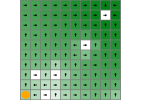

In [3]:

function q_learning_episode!(Q, env; ϵ=0.10, γ=0.99, α=0.05)

    start = time()
    
    function policy(s)
        if rand() < ϵ
            return rand(actions(env))
        else
            return argmax(a->Q[(s, a)], actions(env))
        end
    end

    s = observe(env)
    a = policy(s)
    r = act!(env, a)
    sp = observe(env)
    hist = [s]

    while !terminated(env)
        ap = policy(sp)
        
        a_opt = argmax(a->Q[(sp, a)], actions(env))
        Q[(s, a)] = Q[(s, a)] + α*(r +  γ*Q[(sp,a_opt)] - Q[(s,a)])


        s = sp
        a = ap
        r = act!(env, a)
        sp = observe(env)
        push!(hist, sp)
    end


     a_opt = argmax(a->Q[(sp, a)], actions(env))
    Q[(s, a)] += α*(r +  γ*(Q[(sp,a_opt)]) - Q[(s,a)])


    return (hist=hist, Q = copy(Q), time=time()-start)
end



function q_learning!(env; n_episodes=100, kwargs...)
    Q = Dict((s, a) => 0.0 for s in observations(env), a in actions(env))
    episodes = []
    
    for i in 1:n_episodes
        reset!(env)
        push!(episodes, q_learning_episode!(Q, env;
                                              ϵ=max(0.01, 1-i/n_episodes),
                                              kwargs...))
    end
    
    return episodes
end



q_episodes = q_learning!(env, n_episodes=500000, α=0.01);


Q_temp = q_episodes[500000].Q
reset!(gw)
HW4.render(gw, color=s->maximum(map(a->Q_temp[(s, a)], actions(gw))), policy=s->argmax(a->Q_temp[(s, a)], actions(gw)))




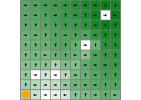

In [4]:

function sarsa_lambda_episode!(Q, env; ϵ=0.10, γ=0.99, α=0.05, λ=0.9)

    start = time()
    
    function policy(s)
        if rand() < ϵ
            return rand(actions(env))
        else
            return argmax(a->Q[(s, a)], actions(env))
        end
    end

    s = observe(env)
    a = policy(s)
    r = act!(env, a)
    sp = observe(env)
    hist = [s]
    N = Dict((s, a) => 0.0)

    while !terminated(env)
        ap = policy(sp)

        N[(s, a)] = get(N, (s, a), 0.0) + 1

        δ = r + γ*Q[(sp, ap)] - Q[(s, a)]

        for ((s, a), n) in N
            Q[(s, a)] += α*δ*n
            N[(s, a)] *= γ*λ
        end

        s = sp
        a = ap
        r = act!(env, a)
        sp = observe(env)
        push!(hist, sp)
    end

    N[(s, a)] = get(N, (s, a), 0.0) + 1
    δ = r - Q[(s, a)]

    for ((s, a), n) in N
        Q[(s, a)] += α*δ*n
        N[(s, a)] *= γ*λ
    end

    return (hist=hist, Q = copy(Q), time=time()-start)
end



function sarsa_lambda!(env; n_episodes=100, kwargs...)
    Q = Dict((s, a) => 0.0 for s in observations(env), a in actions(env))
    episodes = []
    
    for i in 1:n_episodes
        reset!(env)
        push!(episodes, sarsa_lambda_episode!(Q, env;
                                              ϵ=max(0.01, 1-i/n_episodes),
                                              kwargs...))
    end
    
    return episodes
end



lambda_episodes = sarsa_lambda!(env, n_episodes=500000, α=0.01, λ=0.99);


Q_temp = lambda_episodes[500000].Q
reset!(gw)
HW4.render(gw, color=s->maximum(map(a->Q_temp[(s, a)], actions(gw))), policy=s->argmax(a->Q_temp[(s, a)], actions(gw)))




In [ ]:
using Plots

# function evaluate(env, policy, n_episodes=500000, max_steps=1000, γ=1.0)
#     returns = Float64[]
#     for _ in 1:n_episodes
#         t = 0
#         r = 0.0
#         reset!(env)
#         s = observe(env)
#         while !terminated(env)
#             a = policy(s)
#             r += γ^t*act!(env, a)
#             s = observe(env)
#             t += 1
#         end
#         push!(returns, r)
#     end
#     return returns
# end

episodes = Dict("Q_learning"=>q_episodes, "SARSA-λ"=>lambda_episodes)


p = plot(xlabel="steps in environment", ylabel="avg return")
n = 20
stop = 1000
for (name, eps) in episodes
    Q = Dict((s, a) => 0.0 for s in observations(env), a in actions(env))
    xs = [0]
    ys = [mean(evaluate(env, s->argmax(a->Q[(s, a)], actions(env))))]
    for i in n:n:min(stop, length(eps))
        newsteps = sum(length(ep.hist) for ep in eps[i-n+1:i])
        push!(xs, last(xs) + newsteps)
        Q = eps[i].Q
        push!(ys, mean(evaluate(env, s->argmax(a->Q[(s, a)], actions(env)))))
    end    
    plot!(p, xs, ys, label=name)
end
p